In [10]:
import math

import torch
from matplotlib import pyplot as plt
from tqdm import trange
from fewnerd_dataset.database import search_es
from contextual_contrastive_projection_network import hyperparameters
from contextual_contrastive_projection_network.contrastive_loss import ContrastiveLoss
from contextual_contrastive_projection_network.mlp import ContrastiveMLP
from fewnerd_dataset.database import initialize_es
from fewnerd_dataset.llm import compute_llm_output, token_indices_given_text_indices
from hyperparameters import HyperParameters

In [11]:
hp = HyperParameters()
train_types = hyperparameters.TrainTypes.types
test_types = hyperparameters.TestTypes.types
model = ContrastiveMLP(args=hp)
criterion = ContrastiveLoss(margin=hp.triplet_loss_margin)
optimizer = torch.optim.Adam(model.parameters(), lr=hp.lr)

created mlp model:  Sequential(
  (0): Gate(dimension=1024)
  (1): Linear(in_features=1024, out_features=500, bias=True)
  (2): SiLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=500, out_features=500, bias=True)
)


In [12]:
async def yield_dataset(es, fine_types):
	"""
	For each term (fine type) in the train_fine_types, yields a triplet:
	(definition_representation, good_doc_representation, list of bad_doc_representation(s)).
	- definition_representation: forward pass of the term text.
	- good_doc_representation: representation from one random document having fine_type == term.
	- bad_doc_representation: a list (here one sample) computed from a document whose fine_type != term.
	"""
	instances_per_type = hp.instances_per_type
	for term in fine_types:
		# Definition representation: use the term text itself.
		anchor = compute_representation(term)

		# Good document: query for documents where "fine_type" equals the term.
		good_query = {"term": {"fine_type": term}}
		positive_hits = await search_es(es, good_query, size=instances_per_type)
		if not positive_hits:
			continue
		positive_batch = torch.stack([torch.tensor(x["_source"]["llm_output"]) for x in positive_hits])

		negative_batch_count = min(len(positive_hits), instances_per_type)
		hard_negative_ratio = hp.hard_negative_ratio
		hard_negative_count = math.ceil(negative_batch_count * hard_negative_ratio)
		easy_negative_count = negative_batch_count - hard_negative_count
		# Bad document(s): query for documents whose fine_type is different from the term.
		easy_negative_query = {"bool": {"must_not": {"term": {"fine_type": term}}}}
		easy_negative_hits = await search_es(es, easy_negative_query, size=easy_negative_count)
		# For simplicity, sample one bad document representation.
		easy_negative_batch = torch.stack([torch.tensor(x["_source"]["llm_output"]) for x in easy_negative_hits])

		hard_negative_query = {
			"bool": {
				"must": {"match_all": {}},
				"must_not": easy_negative_query["bool"]["must_not"],
				"should": {
					"more_like_this": {
						"fields": [
							"all_text"
						],
						"like": term,
						"min_term_freq": 1,
						"min_doc_freq": 1
					}
				}
			}
		}
		hard_negative_hits = await search_es(es, hard_negative_query, size=hard_negative_count)
		hard_negative_batch = torch.stack([torch.tensor(x["_source"]["llm_output"]) for x in hard_negative_hits])
		# Combine easy and hard negatives.
		negative_batch = torch.cat((easy_negative_batch, hard_negative_batch), dim=0)

		yield anchor, positive_batch, negative_batch

In [13]:
def compute_representation(term):
	"""
	Computes the representation of a term using a pre-trained model.
	For simplicity, this function is a placeholder and should be replaced with actual model inference logic.
	"""
	# Here you would typically use a pre-trained model to compute the representation.
	# For example, using a transformer model or any other embedding technique.
	texts = [term]
	outputs = compute_llm_output(texts)  # Assuming this function is defined elsewhere
	text_indices = [(0, len(term))]  # Assuming the entire term is the text
	_, last_token_idx = token_indices_given_text_indices(term, text_indices[0])
	return outputs[0][last_token_idx].squeeze(0)  # shape: [hidden_dim]

In [14]:
async def train_epoch(es):
	model.train()
	epoch_train_loss = 0.0
	count_loss = 0
	async for anchor, positive_examples, negative_examples in yield_dataset(es, train_types):
		optimizer.zero_grad()
		anchor_mlp = model(anchor).unsqueeze(0)
		positive_mlp = model(positive_examples)
		negative_mlp = model(negative_examples)
		loss = criterion(anchor_mlp, positive_mlp, negative_mlp)
		loss.backward()
		optimizer.step()
		epoch_train_loss += loss.item()
		count_loss += 1
	return epoch_train_loss / count_loss if count_loss else 0.0


async def evaluate_epoch(es):
	model.eval()
	epoch_test_loss = 0.0
	count_loss = 0
	with torch.no_grad():
		async for anchor, positive_examples, negative_examples in yield_dataset(es, test_types):
			anchor_mlp = model(anchor).unsqueeze(0)
			positive_mlp = model(positive_examples)
			negative_mlp = model(negative_examples)
			loss = criterion(anchor_mlp, positive_mlp, negative_mlp)
			epoch_test_loss += loss.item()
			count_loss += 1
	return epoch_test_loss / count_loss if count_loss else 0.0

In [15]:
async def train_mlp(es):
    loss_history = []
    progress_bar = trange(hp.epochs, desc='Epoch 0: Train Loss: 0.0000, Test Loss: 0.0000')
    for epoch in progress_bar:
        avg_train_loss = await train_epoch(es)
        avg_test_loss = await evaluate_epoch(es)
        loss_history.append(avg_test_loss)
        progress_bar.set_description(
            f'Epoch {epoch + 1}/{hp.epochs}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}'
        )
    return loss_history

In [16]:
def display_loss_graph(losses):
	"""
	Plots and saves the training loss curve.
	"""
	plt.figure()
	plt.plot(losses, label='Testing Loss')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend()
	plt.title('Testing Loss')
	plt.show()

Epoch 30/30: Train Loss: 0.0453, Test Loss: 0.0723: 100%|██████████| 30/30 [12:16<00:00, 24.56s/it]


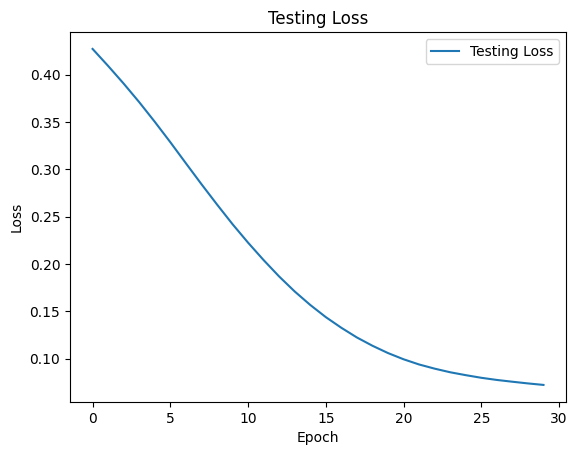

In [17]:

async def main():
	es, index_name = await initialize_es()
	losses = await train_mlp(es)
	display_loss_graph(losses)
	torch.save(model.state_dict(), "../contrastive_projection_net.pt")
	await es.close()

await main()